# Challenge Markov Chain Monte Carlo

### General Imports

In [1]:
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from preprocess_data import generate_data, visualize_data
from submission_example import MCMC_competition

### Load Data and Define Density

In [ ]:
dtype = np.float32
data = pd.read_csv("samples_1.csv", index_col = "Unnamed: 0").to_numpy()

def target_log_prob(param):

    '''
    Log density of our GMM. No need to change here anything.
    '''

    mu_1, mu_2, sigma_1, sigma_2 = param
    
    log_dens = tf.math.reduce_sum(tf.math.log(
        1/(2*tf.math.sqrt(2*math.pi*sigma_1**2)) * tf.math.exp(-0.5*(data - mu_1)**2/sigma_1**2) + 
        1/(2*tf.math.sqrt(2*math.pi*sigma_2**2)) * tf.math.exp(-0.5*(data - mu_2)**2/sigma_2**2))) - 0.5 * (mu_1**2 + mu_2**2) - (sigma_1 + sigma_2)
    
    return(log_dens)

### User Inputs

Change Stuff here. To begin leave everything as is.

In [6]:
init_state = dtype([1, 1, 1, 1])
num_samples = 1000
num_burnin = 10
kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
         target_log_prob_fn=target_log_prob,
         step_size=0.03)

### Generate Samples

This takes some time, in the standard configuration around 40 Seconds on my computer.

In [7]:
#Generate Samples
start_time = time.time()
samples = tfp.mcmc.sample_chain(
    num_results=num_samples,
    current_state=init_state,
    kernel=kernel,
    num_burnin_steps=num_burnin,
    trace_fn=None,
    seed=42)
end_time = time.time()

### Traceplots

Check qualitatively how your sampler performs.

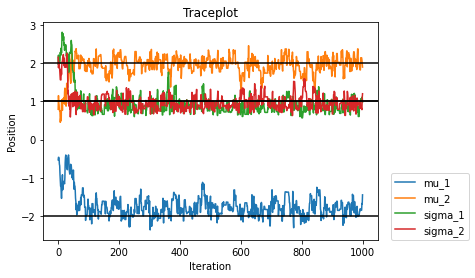

In [5]:
plt.title('Traceplot')
plt.plot(samples.numpy())
plt.xlabel('Iteration')
plt.ylabel('Position')
plt.legend(["mu_1", "mu_2", "sigma_1", "sigma_2"], loc=(1.04, 0))
plt.axhline(y=-2, color='black', linestyle='-')
plt.axhline(y=2, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()

### Evaluation

Check quantitatively how your sampler performs.

In [10]:
sample_mean = tf.reduce_mean(samples, axis=0).numpy()
sample_std = tf.sqrt(
    tf.reduce_mean(
        tf.math.squared_difference(samples, sample_mean),
        axis=0)).numpy()

true_values = [-2, 2, 1, 1]
effective_sample_size = tfp.mcmc.effective_sample_size(samples).numpy()
ESS_mean = round(np.mean(effective_sample_size))
duration_sec = end_time - start_time
Ess_per_sec = round(ESS_mean/duration_sec, 2)


print('Sample Mean:', sample_mean.round(2))
print('Sample Standard Deviation:', sample_std.round(2))
print('True Values:', true_values)
print('Average Effective Sample Size:', ESS_mean)
print('Average ESS per Second:', Ess_per_sec)

Sample Mean: [ 1.95 -1.76  0.94  0.89]
Sample Standard Deviation: [0.2  0.2  0.17 0.16]
True Values: [-2, 2, 1, 1]
Average Effective Sample Size: 117
Average ESS per Second: 3.54


### Your Turn

Now it's your turn to achieve a better performance by *changing the sampling method*.

To start, think about changing the following:

- *num_burnin*, currently the burnin is very low (check out the trace plot!), how about taking a larger value? Don't forget that taking a too high value negatively impacts performance (because we discard high-quality samples).
- *init_state*, ideally our chain already starts close to the true values, can you automatically estimate them from the data?

Next up you could work on:

- *kernel*, try the other kernels from the presentation or a completely new Kernel. You can find a list of all TFP kernels [here](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc).
- *hyperparamters*, in the current version we set *step_size = 0.03*, experiment with different values or start looking into [automatic hyperparameter tuning](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/DualAveragingStepSizeAdaptation). Note: Automatic hyperparameter tuning needs an optimal acceptance probability which depends on the kernel.

And if you have lots of time:

- Incorporate prior knowledge by changing the prior distributions. This is slightly more complicated but very interesting. You can find more details [here](priors.md).

<br/><br/>
<br/><br/>

Please submit us a .py file identical in structure to [the example file](submission_example.py). Here is some example code on how we want to run your code:

```python
submission = MCMC_competition("samples_1.csv")
submission.sample_GMM()
```
Please submit your code in this form so that we can quickly run your code. We will run your code multiple times and average results to mitigate stochasticity.

<br/><br/>
<br/><br/>

You can generate more data and visualize it with code from [this file](preprocess_data.py):


```python
data = generate_data(num_samples = 50, num_modes = 2, mu = [-2, 2], sigma = [1, 1], name = None)

visualize_data(data)
```
Please stay around 50 samples as the algorithms might become numerically unstable for more samples (Bonus Points if you tell us why, Extra Bonus Points if you manage to build numerically stable algorithms for a high amount of samples (> 1000)).

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

tfd = tfp.distributions
dtype = np.float32
data = pd.read_csv("samples_1.csv").set_index("Unnamed: 0").to_numpy()


def target_log_prob(param):
    mu_1, mu_2, sigma_1, sigma_2 = param
    # dens = mu_1 + mu_2
    dens = tf.math.reduce_sum(tf.math.log(
        1/(2*tf.math.sqrt(2*math.pi*sigma_1**2)) * tf.math.exp(-0.5*(data - mu_1)**2/sigma_1**2) + 
        1/(2*tf.math.sqrt(2*math.pi*sigma_2**2)) * tf.math.exp(-0.5*(data - mu_2)**2/sigma_2**2))) - 0.5 * (mu_1**2 + mu_2**2) - (sigma_1 + sigma_2)
    return(dens)

# Define MALA sampler with `step_size` equal to 0.75
samples = tfp.mcmc.sample_chain(
    num_results=1000,
    current_state=dtype([1, 1, 1, 1]),
    kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=target_log_prob,
        step_size=0.02),
    num_burnin_steps=250,
    trace_fn=None,
    seed=42)

sample_mean = tf.reduce_mean(samples, axis=0)
sample_std = tf.sqrt(
    tf.reduce_mean(
        tf.math.squared_difference(samples, sample_mean),
        axis=0))

print('sample mean', sample_mean)
print('sample standard deviation', sample_std)

plt.title('Traceplot')
plt.plot(samples.numpy(), 'b')
plt.xlabel('Iteration')
plt.ylabel('Position')
plt.show()